In [3]:
import tensorflow as tf
import numpy as np

# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Option & PDE parameters
r = 0.05            # Interest rate
T = 1.0             # Maturity
K = 100.0           # Strike

# Asset settings
d = 2                            # Number of assets (modifiable)
sigma = [0.25]*d                # Volatilities
sigma1 = sigma[0]
sigma2 = sigma[1]
rho = 0                       # Correlation coefficient
S_low, S_high = 1e-8, 3*K       # Domain bounds
S_multiplier = 1.2
S_upper = S_high * S_multiplier
t_low = 1e-8

# Neural network parameters
n_layers = 5
n_nodes = 100
learning_rate = 1e-4

# Training parameters
n_samples_pde = 7000
n_samples_terminal = 7000
n_epochs = 15000

2025-05-31 10:15:46.122174: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def payoff(S, kind="put", operator="max"):
    if operator == "max":
        A = tf.reduce_max(S, axis=1, keepdims=True)
    elif operator == "min":
        A = tf.reduce_min(S, axis=1, keepdims=True)
    else:
        raise ValueError("Operator must be 'max' or 'min'")

    if kind == "call":
        return tf.nn.relu(A - K)
    elif kind == "put":
        return tf.nn.relu(K - A)
    else:
        raise ValueError("Kind must be 'call' or 'put'")

In [7]:
class LSTMLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, trans1=tf.nn.tanh, trans2=tf.nn.tanh):
        super().__init__()
        self.trans1 = trans1
        self.trans2 = trans2
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.Uz = self.add_weight(shape=[input_dim, output_dim], initializer="glorot_uniform", name="Uz")
        self.Ug = self.add_weight(shape=[input_dim, output_dim], initializer="glorot_uniform", name="Ug")
        self.Ur = self.add_weight(shape=[input_dim, output_dim], initializer="glorot_uniform", name="Ur")
        self.Uh = self.add_weight(shape=[input_dim, output_dim], initializer="glorot_uniform", name="Uh")

        self.Wz = self.add_weight(shape=[output_dim, output_dim], initializer="glorot_uniform", name="Wz")
        self.Wg = self.add_weight(shape=[output_dim, output_dim], initializer="glorot_uniform", name="Wg")
        self.Wr = self.add_weight(shape=[output_dim, output_dim], initializer="glorot_uniform", name="Wr")
        self.Wh = self.add_weight(shape=[output_dim, output_dim], initializer="glorot_uniform", name="Wh")

        self.bz = self.add_weight(shape=[1, output_dim], initializer="zeros", name="bz")
        self.bg = self.add_weight(shape=[1, output_dim], initializer="zeros", name="bg")
        self.br = self.add_weight(shape=[1, output_dim], initializer="zeros", name="br")
        self.bh = self.add_weight(shape=[1, output_dim], initializer="zeros", name="bh")

    def call(self, S, X):
        Z = self.trans1(tf.matmul(X, self.Uz) + tf.matmul(S, self.Wz) + self.bz)
        G = self.trans1(tf.matmul(X, self.Ug) + tf.matmul(S, self.Wg) + self.bg)
        R = self.trans1(tf.matmul(X, self.Ur) + tf.matmul(S, self.Wr) + self.br)
        H = self.trans2(tf.matmul(X, self.Uh) + tf.matmul(R * S, self.Wh) + self.bh)
        return (1 - G) * H + Z * S

In [9]:
class DGMNet(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, n_layers):
        super().__init__()
        self.input_layer = tf.keras.layers.Dense(hidden_dim, activation='tanh')

        self.hidden_layers = [LSTMLayer(input_dim, hidden_dim) for _ in range(n_layers)]
        self.output_layer = tf.keras.layers.Dense(1, activation=None)

    def call(self, t, *S):
        X = tf.concat([t] + list(S), axis=1)
        S_out = self.input_layer(X)

        for lstm in self.hidden_layers:
            S_out = lstm(S_out, X)

        return self.output_layer(S_out)

In [11]:
def sampler(n_pde, n_terminal, d):
    t_pde = np.random.uniform(t_low, T, size=(n_pde, 1))
    S_pde = np.random.uniform(S_low, S_upper, size=(n_pde, d))

    t_terminal = T * np.ones((n_terminal, 1))
    S_terminal = np.random.uniform(S_low, S_upper, size=(n_terminal, d))

    return map(lambda x: tf.convert_to_tensor(x, dtype=tf.float32),
               [t_pde, S_pde, t_terminal, S_terminal])

In [13]:
@tf.function
def compute_loss(model, t_pde, S_pde, t_term, S_term, payoff_kind="call", payoff_op="max"):
    S_split = tf.split(S_pde, d, axis=1)

    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([t_pde] + S_split)

        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([t_pde] + S_split)
            V = model(t_pde, *S_split)

        V_t = tape1.gradient(V, t_pde)
        V_s = [tape1.gradient(V, S_split[i]) for i in range(d)]

    V_ss = [tape2.gradient(V_s[i], S_split[i]) for i in range(d)]

    # Résidu PDE
    pde = V_t
    for i in range(d):
        Si = S_split[i]
        pde += r * Si * V_s[i] + 0.5 * sigma[i]**2 * Si**2 * V_ss[i]
    pde -= r * V

    loss_pde = tf.reduce_mean(tf.square(pde))

    # Terminal loss
    V_terminal = model(t_term, *tf.split(S_term, d, axis=1))
    payoff_target = payoff(S_term, kind=payoff_kind, operator=payoff_op)
    loss_terminal = tf.reduce_mean(tf.square(V_terminal - payoff_target))

    return loss_pde + loss_terminal, loss_pde, loss_terminal

In [13]:
# Initialisation du modèle
model = DGMNet(input_dim=d+1, hidden_dim=n_nodes, n_layers=n_layers)
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def train_step(t_pde, S_pde, t_term, S_term):
    with tf.GradientTape() as tape:
        loss_total, l_pde, l_term = compute_loss(
            model, t_pde, S_pde, t_term, S_term,
            payoff_kind="put", payoff_op="max"
        )
    grads = tape.gradient(loss_total, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_total, l_pde, l_term


# Entraînement
for epoch in range(n_epochs):
    t_pde, S_pde, t_term, S_term = sampler(
        n_samples_pde, n_samples_terminal, d
    )
    loss_total, l_pde, l_term = train_step(
        t_pde, S_pde, t_term, S_term
    )
    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d} | Total: {loss_total:.5e} | PDE: {l_pde:.2e} | Terminal: {l_term:.2e}")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:1407: UserWarning: Layer 'dgm_net' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''DGMNet.call() got an unexpected keyword argument 'S'''
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'dgm_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This w

Epoch     0 | Total: 3.63073e+03 | PDE: 3.49e+03 | Terminal: 1.40e+02
Epoch   500 | Total: 2.79181e+01 | PDE: 1.42e+01 | Terminal: 1.37e+01
Epoch  1000 | Total: 1.00122e+01 | PDE: 6.68e+00 | Terminal: 3.33e+00
Epoch  1500 | Total: 6.20435e+00 | PDE: 4.01e+00 | Terminal: 2.19e+00
Epoch  2000 | Total: 4.59797e+00 | PDE: 3.08e+00 | Terminal: 1.52e+00
Epoch  2500 | Total: 3.35127e+00 | PDE: 2.21e+00 | Terminal: 1.14e+00
Epoch  3000 | Total: 2.56369e+00 | PDE: 1.72e+00 | Terminal: 8.40e-01
Epoch  3500 | Total: 2.42428e+00 | PDE: 1.71e+00 | Terminal: 7.17e-01
Epoch  4000 | Total: 1.79230e+00 | PDE: 1.25e+00 | Terminal: 5.46e-01
Epoch  4500 | Total: 1.58275e+00 | PDE: 1.09e+00 | Terminal: 4.97e-01
Epoch  5000 | Total: 1.25948e+00 | PDE: 8.06e-01 | Terminal: 4.54e-01
Epoch  5500 | Total: 1.14785e+00 | PDE: 8.13e-01 | Terminal: 3.35e-01
Epoch  6000 | Total: 1.32723e+00 | PDE: 9.88e-01 | Terminal: 3.39e-01
Epoch  6500 | Total: 9.91818e-01 | PDE: 7.01e-01 | Terminal: 2.91e-01
Epoch  7000 | Total:

In [2]:
'''
model.save_weights("model_dgmnet_final_put_bo_5050.weights.h5")
print("Les poids finaux ont été sauvegardés dans 'model_dgmnet_final_put_bo_5050.weights.h5'")
'''

'\nmodel.save_weights("model_dgmnet_final_put_bo_5050.weights.h5")\nprint("Les poids finaux ont été sauvegardés dans \'model_dgmnet_final_put_bo_5050.weights.h5\'")\n'

In [15]:
model = DGMNet(input_dim=d+1, hidden_dim=n_nodes, n_layers=n_layers)

dummy_input_S = tf.random.uniform((1, d))
dummy_input_t = tf.random.uniform((1, 1))
model(dummy_input_t, dummy_input_S)

# Chargement des poids
model.load_weights("model_dgmnet_final_put_bo_5050.weights.h5")
print("Les poids finaux ont été rechargés avec succès.")

Les poids finaux ont été rechargés avec succès.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:1407: UserWarning: Layer 'dgm_net' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''DGMNet.call() got an unexpected keyword argument 'S'''
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'dgm_net', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This w

In [4]:
'''
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
checkpoint.save("checkpoints/dgmnet_ckpt")
print("Checkpoint sauvegardé.")
'''

'\ncheckpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)\ncheckpoint.save("checkpoints/dgmnet_ckpt")\nprint("Checkpoint sauvegardé.")\n'

In [19]:
'''
# Recharger le dernier checkpoint
latest_checkpoint = tf.train.latest_checkpoint("checkpoints")
checkpoint.restore(latest_checkpoint)
print(f"Checkpoint {latest_checkpoint} rechargé.")
'''

'\n# Recharger le dernier checkpoint\nlatest_checkpoint = tf.train.latest_checkpoint("checkpoints")\ncheckpoint.restore(latest_checkpoint)\nprint(f"Checkpoint {latest_checkpoint} rechargé.")\n'

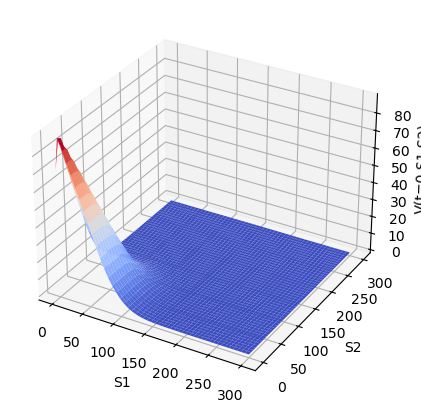

In [21]:
import matplotlib.pyplot as plt

def plot_surface1(model, t_fixed=1.0, d=2, n_grid=50):
    S1 = np.linspace(S_low, S_high, n_grid)
    S2 = np.linspace(S_low, S_high, n_grid)
    S1_grid, S2_grid = np.meshgrid(S1, S2)

    t_plot = t_fixed * np.ones_like(S1_grid)
    inputs = [t_plot.reshape(-1, 1), S1_grid.reshape(-1, 1), S2_grid.reshape(-1, 1)]

    with tf.device("/cpu:0"):  # pour éviter surchauffe GPU
        pred = model(*inputs).numpy().reshape(n_grid, n_grid)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(S1_grid, S2_grid, pred, cmap="coolwarm")
    ax.set_xlabel("S1")
    ax.set_ylabel("S2")
    ax.set_zlabel(f"V(t={t_fixed},S1,S2)", labelpad=1)
    #ax.set_title(f"Prediction surface at t = {t_fixed}")
    #plt.savefig("CH2_PUT_BO_5050_0.png", dpi=300)
    plt.show()

plot_surface1(model,0,d=2)

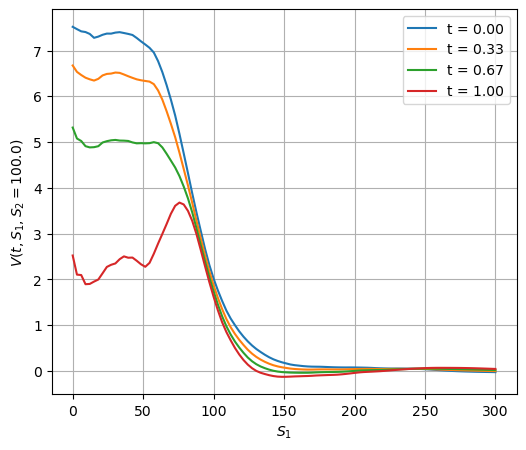

In [27]:
import matplotlib.pyplot as plt

def plot_temporal_slices(model, S2_fixed=100.0, t_list=[0, T/3, 2*T/3, T], n_points=100):
    """
    Trace V(t, S1, S2_fixed) pour plusieurs t donnés.
    """
    S1_vals = np.linspace(S_low, S_high, n_points).reshape(-1, 1)
    S2_vals = np.full_like(S1_vals, S2_fixed)

    plt.figure(figsize=(6, 5))

    for t in t_list:
        t_vals = np.full_like(S1_vals, t)
        inputs = [tf.convert_to_tensor(t_vals, dtype=tf.float32),
                  tf.convert_to_tensor(S1_vals, dtype=tf.float32),
                  tf.convert_to_tensor(S2_vals, dtype=tf.float32)]

        with tf.device("/cpu:0"):
            preds = model(*inputs).numpy()

        plt.plot(S1_vals, preds, label=f"t = {t:.2f}")

    plt.xlabel(r"$S_1$")
    plt.ylabel(r"$V(t, S_1, S_2 = %.1f)$" % S2_fixed)
    plt.legend()
    plt.grid(True)
    #plt.savefig("CH2_PUT_BO_5050_slices.png", dpi=300)
    plt.show()

plot_temporal_slices(model, S2_fixed=100)

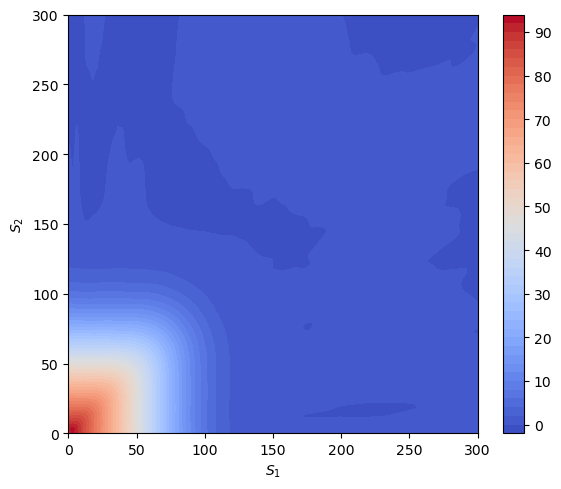

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def plot_contour_solution(model, t_fixed=1.0, n_grid=100):
    """
    Trace une heatmap 2D de la solution V(t, S1, S2) à temps fixé (par défaut maturité t=1).
    """
    S1 = np.linspace(S_low, S_high, n_grid)
    S2 = np.linspace(S_low, S_high, n_grid)
    S1_grid, S2_grid = np.meshgrid(S1, S2)

    t_vals = t_fixed * np.ones_like(S1_grid)

    # Préparation des inputs
    t_input = tf.convert_to_tensor(t_vals.reshape(-1, 1), dtype=tf.float32)
    S1_input = tf.convert_to_tensor(S1_grid.reshape(-1, 1), dtype=tf.float32)
    S2_input = tf.convert_to_tensor(S2_grid.reshape(-1, 1), dtype=tf.float32)

    # Prédiction
    with tf.device("/cpu:0"):
        V_pred = model(t_input, S1_input, S2_input).numpy().reshape(n_grid, n_grid)

    # Affichage
    plt.figure(figsize=(6, 5))
    contour = plt.contourf(S1_grid, S2_grid, V_pred, levels=50, cmap="coolwarm")
    plt.xlabel("$S_1$")
    plt.ylabel("$S_2$")
    #plt.title(f"Option value at t = {t_fixed}")
    plt.colorbar(contour)
    #plt.savefig("CH2_PUT_BO_2D_5050_033.png", dpi=300)
    plt.tight_layout()
    plt.show()

plot_contour_solution(model, t_fixed=0.33)

In [33]:
def plot_surface_time_vs_S1(model, S2_fixed=100.0, n_points=100):
    """
    Trace V(t, S1, S2_fixed) en surface 3D (t sur x, S1 sur y, V sur z)
    """
    t_vals = np.linspace(t_low, T, n_points)
    S1_vals = np.linspace(S_low, S_high, n_points)

    T_grid, S1_grid = np.meshgrid(t_vals, S1_vals)
    S2_grid = S2_fixed * np.ones_like(T_grid)

    t_input = tf.convert_to_tensor(T_grid.reshape(-1, 1), dtype=tf.float32)
    S1_input = tf.convert_to_tensor(S1_grid.reshape(-1, 1), dtype=tf.float32)
    S2_input = tf.convert_to_tensor(S2_grid.reshape(-1, 1), dtype=tf.float32)

    with tf.device("/cpu:0"):
        V_pred = model(t_input, S1_input, S2_input).numpy().reshape(n_points, n_points)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(T_grid, S1_grid, V_pred, cmap="coolwarm", edgecolor="none")
    ax.set_xlabel("t")
    ax.set_ylabel("$S_1$")
    ax.set_zlabel(f"$V(t, S_1, S_2 = {S2_fixed})$",labelpad=1)
    #ax.set_title("Surface plot of option value over time and $S_1$")
    #plt.savefig("CH2_PUT_BO_5050_S2100.png", dpi=300)
    plt.tight_layout()
    plt.show()

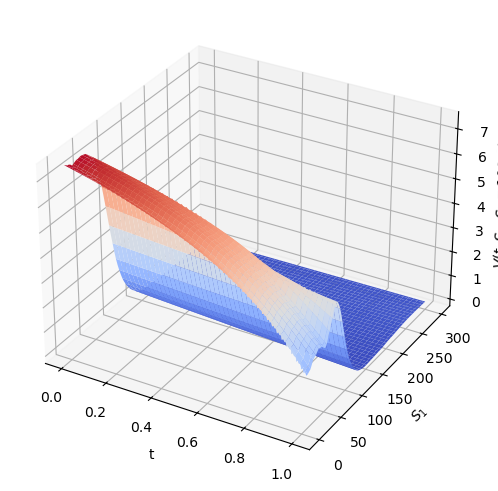

In [35]:
plot_surface_time_vs_S1(model, S2_fixed=100.0)

In [37]:
def monte_carlo_max_put(S1, S2, t, K, T, r, sigma1, sigma2, rho=0.0, n_paths=1000000, seed=42):
    np.random.seed(seed)
    dt = T - t
    S1 = np.array(S1).reshape(-1, 1)
    S2 = np.array(S2).reshape(-1, 1)
    n_samples = S1.shape[0]
    Z1 = np.random.randn(n_samples, n_paths)
    Z2 = rho * Z1 + np.sqrt(1 - rho**2) * np.random.randn(n_samples, n_paths)
    S1_T = S1 * np.exp((r - 0.5 * sigma1**2) * dt + sigma1 * np.sqrt(dt) * Z1)
    S2_T = S2 * np.exp((r - 0.5 * sigma2**2) * dt + sigma2 * np.sqrt(dt) * Z2)
    payoff = np.maximum(K - np.maximum(S1_T, S2_T), 0)
    return np.exp(-r * dt) * np.mean(payoff, axis=1)

# Grille S1/S2
n_grid = 50
S1_vals = np.linspace(S_low, S_high, n_grid)
S2_vals = np.linspace(S_low, S_high, n_grid)
S1_grid, S2_grid = np.meshgrid(S1_vals, S2_vals)
S1_flat = S1_grid.flatten()
S2_flat = S2_grid.flatten()

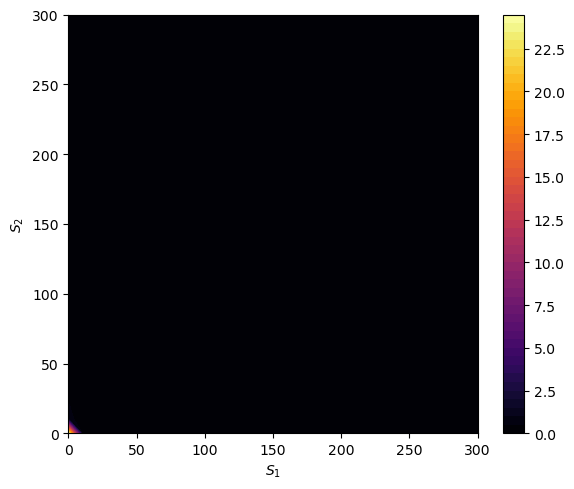

,0.00,10.34,20.69,31.03,41.38,51.72,62.07,72.41,82.76,93.10,...,206.90,217.24,227.59,237.93,248.28,258.62,268.97,279.31,289.66,300.00
0.00,24.210322,0.209949,0.275662,0.243796,0.184065,0.119941,0.163518,0.175864,0.025218,0.195433,...,0.027573,0.026462,0.025388,0.024613,0.026547,0.029271,0.031645,0.033280,0.033858,0.033482
10.34,0.784579,0.051126,0.038910,0.007558,0.057557,0.002744,0.067495,0.054697,0.073595,0.124359,...,0.012417,0.004144,0.002413,0.004010,0.008078,0.014508,0.021960,0.030245,0.039285,0.048960
20.69,0.532855,0.041350,0.007246,0.009777,0.008763,0.050370,0.077684,0.036509,0.010444,0.044322,...,0.008590,0.006750,0.004353,0.003760,0.005259,0.008215,0.010765,0.013274,0.015985,0.018810
31.03,0.263727,0.098260,0.101884,0.052453,0.134153,0.070554,0.055219,0.088942,0.087766,0.061733,...,0.013881,0.008387,0.012682,0.023057,0.033770,0.041463,0.048308,0.056927,0.068500,0.082403
41.38,0.376845,0.010873,0.018947,0.007151,0.143980,0.017547,0.161031,0.033081,0.034687,0.119686,...,0.009201,0.005860,0.011774,0.017394,0.028206,0.037320,0.045768,0.056224,0.068703,0.082051
51.72,0.159404,0.046602,0.056219,0.021640,0.019948,0.139730,0.093455,0.031153,0.097535,0.192681,...,0.004313,0.010225,0.007498,0.004481,0.011557,0.016688,0.024678,0.035104,0.047144,0.060668
62.07,0.103588,0.107010,0.048685,0.110496,0.060660,0.075585,0.055770,0.078315,0.121847,0.326231,...,0.015934,0.010194,0.008186,0.009180,0.006080,0.001800,0.002282,0.007601,0.014195,0.019373
72.41,0.049042,0.037273,0.070661,0.118581,0.107423,0.011000,0.010940,0.211393,0.064495,0.148002,...,0.006091,0.006512,0.004155,0.001794,0.003040,0.000448,0.004117,0.008265,0.010888,0.012281
82.76,0.168495,0.007352,0.031027,0.074404,0.170386,0.145378,0.030158,0.174089,0.136806,0.074477,...,0.035570,0.037638,0.032368,0.021487,0.013122,0.009241,0.004768,0.000031,0.004912,0.010154
93.10,0.072197,0.105834,0.095580,0.120535,0.155259,0.006725,0.152920,0.113936,0.062276,0.058022,...,0.057455,0.055666,0.055602,0.043622,0.023824,0.009468,0.000940,0.007684,0.015002,0.024160


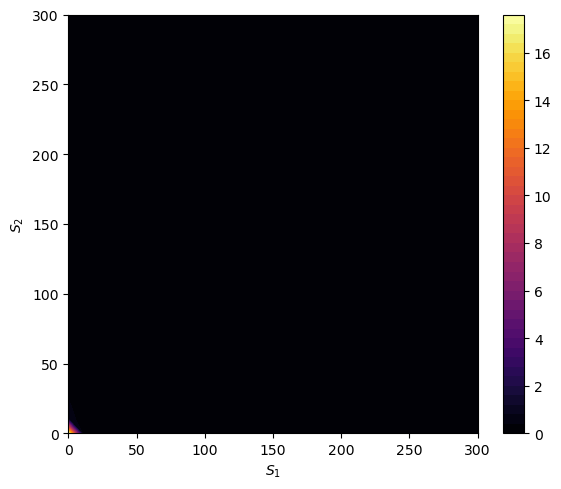

,0.00,10.34,20.69,31.03,41.38,51.72,62.07,72.41,82.76,93.10,...,206.90,217.24,227.59,237.93,248.28,258.62,268.97,279.31,289.66,300.00
0.00,17.481559,0.162531,0.293601,0.221168,0.115838,0.090458,0.101841,0.149647,0.008087,0.152889,...,0.014459,0.018217,0.020390,0.022875,0.026387,0.030059,0.032950,0.034456,0.034469,0.033313
10.34,0.790847,0.010493,0.007823,0.007185,0.080240,0.020647,0.012674,0.034592,0.039881,0.056300,...,0.003778,0.005369,0.008181,0.011621,0.015484,0.019412,0.023302,0.027208,0.031358,0.036197
20.69,0.476813,0.031099,0.041383,0.041856,0.039964,0.070431,0.004528,0.171105,0.111600,0.104762,...,0.000674,0.004665,0.006863,0.006080,0.002969,0.001369,0.005550,0.008946,0.011677,0.013964
31.03,0.260385,0.099187,0.065295,0.043790,0.105716,0.071857,0.104937,0.075606,0.033850,0.101161,...,0.027754,0.025504,0.021436,0.018877,0.019121,0.021871,0.026771,0.033941,0.043714,0.055871
41.38,0.303021,0.040543,0.054884,0.057443,0.023967,0.076038,0.238106,0.113538,0.111571,0.100160,...,0.015996,0.010783,0.010141,0.013490,0.021049,0.027060,0.032726,0.039669,0.048342,0.058402
51.72,0.137669,0.050070,0.050844,0.024945,0.013314,0.159267,0.179825,0.009495,0.037272,0.069651,...,0.013702,0.005690,0.004281,0.010411,0.014756,0.016074,0.017764,0.022090,0.029541,0.039962
62.07,0.075206,0.057997,0.047263,0.068086,0.012983,0.037848,0.151884,0.153386,0.075847,0.004698,...,0.014875,0.018856,0.017883,0.014493,0.012715,0.012145,0.011569,0.012174,0.013423,0.014063
72.41,0.006244,0.005733,0.130296,0.036584,0.054982,0.061318,0.070591,0.221210,0.138522,0.109175,...,0.022555,0.027393,0.030336,0.030280,0.029893,0.025426,0.019563,0.011963,0.004182,0.001540
82.76,0.159922,0.046783,0.153129,0.056958,0.179557,0.009327,0.072090,0.166866,0.105935,0.132636,...,0.039538,0.050544,0.051959,0.045674,0.041382,0.037327,0.032222,0.026143,0.018628,0.010458
93.10,0.162348,0.122696,0.071359,0.059264,0.176906,0.029660,0.041328,0.056695,0.066639,0.006788,...,0.042906,0.049314,0.054317,0.052626,0.044007,0.033829,0.024987,0.018331,0.010530,0.001119


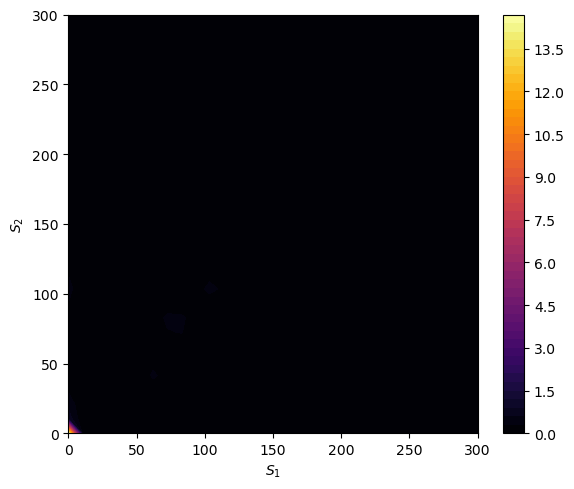

,0.00,10.34,20.69,31.03,41.38,51.72,62.07,72.41,82.76,93.10,...,206.90,217.24,227.59,237.93,248.28,258.62,268.97,279.31,289.66,300.00
0.00,14.620690,0.162134,0.291314,0.163124,0.067447,0.124174,0.101570,0.074991,0.122278,0.199128,...,0.016180,0.021463,0.025241,0.028945,0.032767,0.036138,0.038244,0.038594,0.037238,0.034585
10.34,0.791539,0.061969,0.002819,0.021811,0.059499,0.032282,0.038054,0.067938,0.099621,0.129474,...,0.002509,0.005692,0.011942,0.016462,0.019220,0.020407,0.020443,0.019858,0.019250,0.019308
20.69,0.511924,0.058061,0.028303,0.063898,0.049352,0.062452,0.072813,0.253522,0.175908,0.158738,...,0.007474,0.000168,0.003219,0.003436,0.001724,0.000999,0.003929,0.006339,0.007899,0.008786
31.03,0.258132,0.136261,0.065710,0.034560,0.124829,0.064436,0.181493,0.164970,0.103728,0.206321,...,0.031117,0.023149,0.009716,0.001475,0.006409,0.006774,0.004381,0.000640,0.008440,0.018425
41.38,0.159828,0.127802,0.068073,0.052410,0.030824,0.104239,0.338088,0.214002,0.104268,0.198575,...,0.020250,0.012816,0.007373,0.007423,0.009493,0.008712,0.008661,0.012158,0.019658,0.031024
51.72,0.128824,0.055488,0.031237,0.061118,0.011694,0.172404,0.232893,0.067666,0.038559,0.094630,...,0.022636,0.015226,0.012337,0.015857,0.018387,0.016792,0.013630,0.014024,0.018162,0.024167
62.07,0.069196,0.007698,0.046573,0.048739,0.112691,0.081967,0.010632,0.067559,0.153747,0.001879,...,0.039761,0.042831,0.040251,0.033745,0.026981,0.022203,0.017519,0.015108,0.012649,0.010489
72.41,0.066569,0.082050,0.011734,0.064406,0.023559,0.013483,0.006470,0.280028,0.311416,0.177083,...,0.037567,0.051230,0.057768,0.057575,0.054885,0.049161,0.040526,0.029215,0.015947,0.005660
82.76,0.237235,0.051024,0.086134,0.008606,0.098389,0.001509,0.132410,0.354455,0.350812,0.175718,...,0.042136,0.062532,0.072860,0.073334,0.072295,0.066333,0.058741,0.050269,0.040474,0.029275
93.10,0.291792,0.116778,0.009169,0.029995,0.047117,0.054831,0.013819,0.157848,0.133293,0.112342,...,0.019126,0.040582,0.056198,0.064734,0.065411,0.060623,0.053835,0.046539,0.036897,0.024924


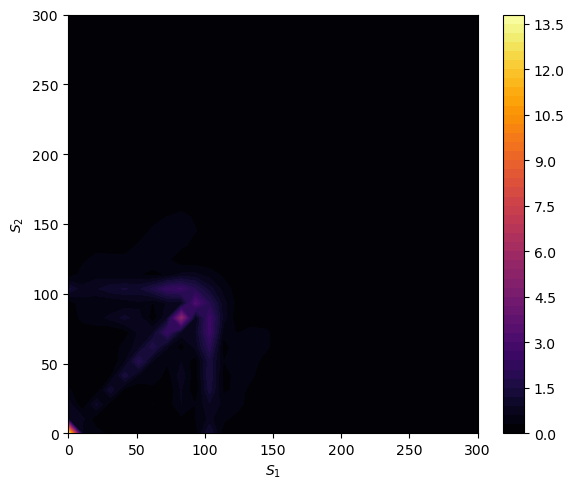

,0.00,10.34,20.69,31.03,41.38,51.72,62.07,72.41,82.76,93.10,...,206.90,217.24,227.59,237.93,248.28,258.62,268.97,279.31,289.66,300.00
0.00,13.584915,0.249189,0.459843,0.197382,0.147438,0.276800,0.257885,0.020269,0.162550,0.110074,...,0.031418,0.035760,0.039799,0.043991,0.047813,0.050402,0.050952,0.049143,0.045289,0.040055
10.34,0.802664,0.711233,0.033085,0.001772,0.061379,0.107416,0.187297,0.219999,0.211897,0.282534,...,0.003672,0.005869,0.012897,0.017150,0.018453,0.017050,0.013589,0.008907,0.003900,0.000522
20.69,0.765934,0.025601,0.955952,0.077329,0.073441,0.036925,0.304016,0.098663,0.600812,0.297105,...,0.034881,0.023173,0.016286,0.012096,0.008859,0.006181,0.004363,0.003238,0.002151,0.000811
31.03,0.337145,0.128942,0.033766,1.144304,0.138000,0.124139,0.147293,0.035323,0.625111,0.043210,...,0.018602,0.001550,0.020327,0.033675,0.040574,0.043668,0.043880,0.040885,0.034900,0.027097
41.38,0.112019,0.171421,0.041912,0.225147,1.405583,0.482515,0.563076,0.130661,0.788888,0.033096,...,0.030858,0.014954,0.000121,0.010036,0.019398,0.031399,0.036803,0.031589,0.018160,0.000270
51.72,0.303099,0.021047,0.021116,0.083979,0.497366,1.888151,0.532669,0.341417,0.573702,0.098777,...,0.030283,0.021249,0.016517,0.020277,0.021733,0.016831,0.009333,0.006450,0.007738,0.007275
62.07,0.109471,0.124630,0.164894,0.069912,0.427787,0.724197,1.754250,0.635879,0.126473,0.697066,...,0.063799,0.064386,0.060187,0.049542,0.036635,0.026321,0.017474,0.014706,0.011232,0.007794
72.41,0.241544,0.142545,0.158289,0.002529,0.134222,0.652568,0.835975,2.387581,0.780455,0.829818,...,0.057627,0.078708,0.086702,0.083766,0.078253,0.071056,0.059252,0.043799,0.023810,0.007809
82.76,0.091536,0.378995,0.445893,0.705708,0.997490,0.712563,0.093400,0.855979,5.137190,0.565984,...,0.045745,0.077500,0.096732,0.105286,0.104927,0.095213,0.083839,0.072763,0.060851,0.046491
93.10,0.012842,0.546104,0.327982,0.280348,0.370618,0.518874,0.275544,0.634694,0.670121,3.090560,...,0.009761,0.031262,0.060229,0.079866,0.088756,0.089839,0.085342,0.076167,0.062876,0.046995


In [39]:
import pandas as pd

for i, t_fixed in enumerate([0.0, T/3, 2*T/3, T]):
    # Monte Carlo
    V_MC_flat = monte_carlo_max_put(S1_flat, S2_flat, t_fixed, K, T, r, sigma1, sigma2, rho, 100000)

    # PINN
    t_tensor = tf.convert_to_tensor(np.full_like(S1_flat, t_fixed).reshape(-1, 1), dtype=tf.float32)
    S1_tensor = tf.convert_to_tensor(S1_flat.reshape(-1, 1), dtype=tf.float32)
    S2_tensor = tf.convert_to_tensor(S2_flat.reshape(-1, 1), dtype=tf.float32)
    V_PINN_flat = model(t_tensor, S1_tensor, S2_tensor).numpy().flatten()

    abs_error = np.abs(V_MC_flat - V_PINN_flat).reshape(n_grid, n_grid)

    # Heatmap
    plt.figure(figsize=(6, 5))
    plt.contourf(S1_grid, S2_grid, abs_error, levels=50, cmap="inferno")
    plt.colorbar()
    plt.xlabel("$S_1$")
    plt.ylabel("$S_2$")
    plt.tight_layout()
    #plt.savefig(f"CH2_Put_BO_5050_ERROR_{8+i}4_MC100.png", dpi=300)
    plt.show()

    # Tableau d'erreur
    df_error = pd.DataFrame(abs_error, index=np.round(S2_vals, 2), columns=np.round(S1_vals, 2))
    display(df_error)

    # Sauvegarde Excel
    #df_error.to_excel(f"CH2_Put_BO_error_table_5050_{8+i}4_MC100.xlsx")

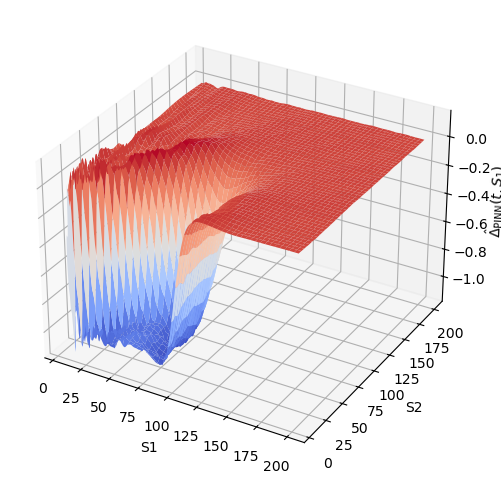

In [57]:
def plot_delta_surface_S1(model, t_fixed=1.0, d=2, n_grid=200, asset_index=0, S_max_focus=150):
    """
    Trace la surface du Delta sur la zone S1, S2 ∈ [S_low+epsilon, S_max_focus].
    """
    epsilon = 7
    S1 = np.linspace(S_low + epsilon, S_max_focus, n_grid)
    S2 = np.linspace(S_low + epsilon, S_max_focus, n_grid)
    S1_grid, S2_grid = np.meshgrid(S1, S2)
    
    t_plot = t_fixed * np.ones_like(S1_grid)
    inputs = tf.convert_to_tensor(
        np.column_stack((
            t_plot.reshape(-1, 1),
            S1_grid.reshape(-1, 1),
            S2_grid.reshape(-1, 1)
        )),
        dtype=tf.float32
    )
    
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        V_pred = model(inputs)

    dV_dS = tape.gradient(V_pred, inputs)
    delta = dV_dS[:, asset_index + 1].numpy()
    delta_grid = delta.reshape(n_grid, n_grid)
    
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(S1_grid, S2_grid, delta_grid, cmap='coolwarm')
    ax.set_xlabel("S1")
    ax.set_ylabel("S2")
    ax.set_zlabel(r'$\hat{\Delta}_{\mathrm{PINN}}(t, S_1)$', labelpad=1)
    plt.savefig("CH2_PUT_BO_5050_DELTA_S1_FOCUS_T1.png", dpi=300)
    plt.tight_layout()
    plt.show()

plot_delta_surface_S1(model, t_fixed=1, d=2, n_grid=500, asset_index=0, S_max_focus=200)

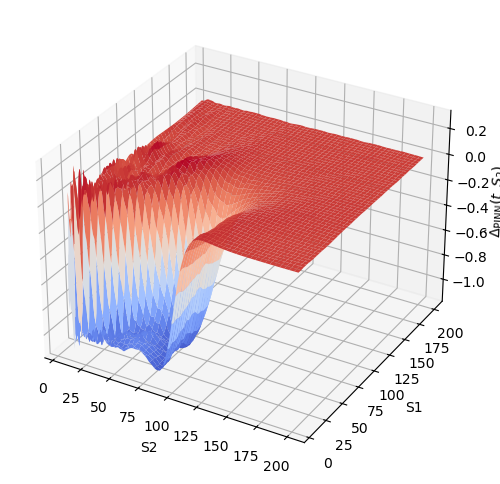

In [86]:
def plot_delta_surface_S2(model, t_fixed=1.0, d=2, n_grid=200, S_max_focus=150):
    """
    Trace la surface du Delta par rapport à S2 (asset_index=1) sur la zone S1, S2 ∈ [S_low+epsilon, S_max_focus].
    """
    epsilon = 7
    S1 = np.linspace(S_low + epsilon, S_max_focus, n_grid)
    S2 = np.linspace(S_low + epsilon, S_max_focus, n_grid)
    S1_grid, S2_grid = np.meshgrid(S1, S2)
    
    t_plot = t_fixed * np.ones_like(S1_grid)
    inputs = tf.convert_to_tensor(
        np.column_stack((
            t_plot.reshape(-1, 1),
            S1_grid.reshape(-1, 1),
            S2_grid.reshape(-1, 1)
        )),
        dtype=tf.float32
    )
    
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        V_pred = model(inputs)

    dV_dS = tape.gradient(V_pred, inputs)
    delta = dV_dS[:, 2].numpy()  # 2e actif (index=2 pour S2)
    delta_grid = delta.reshape(n_grid, n_grid)

    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(S2_grid, S1_grid, delta_grid, cmap='coolwarm')
    ax.set_xlabel("S2")
    ax.set_ylabel("S1")
    ax.set_zlabel(r'$\hat{\Delta}_{\mathrm{PINN}}(t, S_2)$', labelpad=1)    
    plt.savefig("CH2_PUT_BO_5050_DELTA_S2_FOCUS_T1.png", dpi=300)
    plt.tight_layout()
    plt.show()

plot_delta_surface_S2(model, t_fixed=1, d=2, n_grid=500, S_max_focus=200)

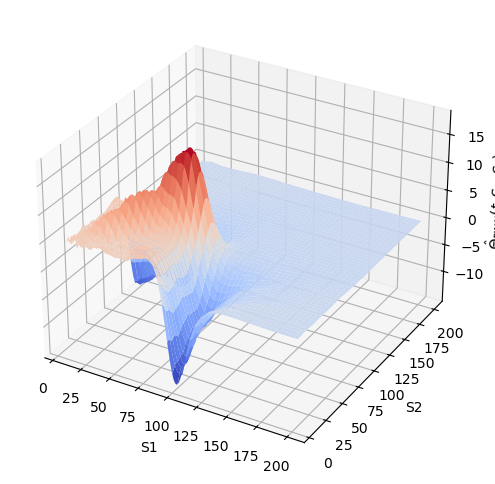

In [69]:
def plot_theta_surface(model, t_fixed=1.0, d=2, n_grid=200, S_max_focus=150):
    """
    Trace la surface du Theta (dérivée par rapport au temps) sur la zone S1, S2 ∈ [S_low+epsilon, S_max_focus].
    """
    epsilon = 7
    S1 = np.linspace(S_low + epsilon, S_max_focus, n_grid)
    S2 = np.linspace(S_low + epsilon, S_max_focus, n_grid)
    S1_grid, S2_grid = np.meshgrid(S1, S2)
    
    t_plot = t_fixed * np.ones_like(S1_grid)
    inputs = tf.convert_to_tensor(
        np.column_stack((
            t_plot.reshape(-1, 1),
            S1_grid.reshape(-1, 1),
            S2_grid.reshape(-1, 1)
        )),
        dtype=tf.float32
    )
    
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        V_pred = model(inputs)

    dV_dX = tape.gradient(V_pred, inputs)
    theta = dV_dX[:, 0].numpy()
    theta_grid = theta.reshape(n_grid, n_grid)
    
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(S1_grid, S2_grid, theta_grid, cmap='coolwarm')
    ax.set_xlabel("S1")
    ax.set_ylabel("S2")
    ax.set_zlabel(r'$\hat{\Theta}_{\mathrm{PINN}}(t, S_1, S_2)$', labelpad=1)    
    plt.savefig("CH2_PUT_BO_5050_THETA_FOCUS_T1.png", dpi=300)
    plt.tight_layout()
    plt.show()

plot_theta_surface(model, t_fixed=1, d=2, n_grid=500, S_max_focus=200)

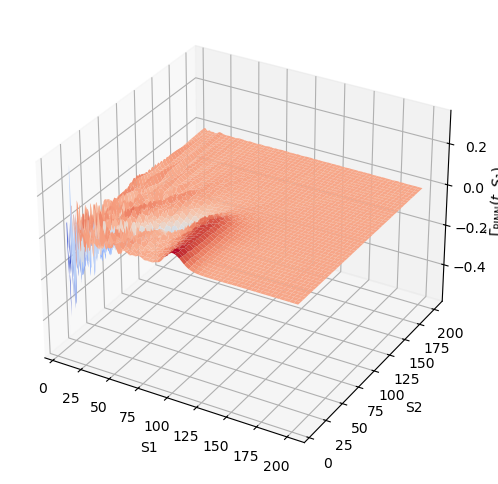

In [78]:
def plot_gamma_surface_S1(model, t_fixed=1.0, d=2, n_grid=200, S_max_focus=150):
    """
    Trace la surface du Gamma (dérivée seconde par rapport à S1) sur la zone S1, S2 ∈ [S_low+epsilon, S_max_focus].
    """
    epsilon = 7 
    S1 = np.linspace(S_low + epsilon, S_max_focus, n_grid)
    S2 = np.linspace(S_low + epsilon, S_max_focus, n_grid)
    S1_grid, S2_grid = np.meshgrid(S1, S2)
    
    t_plot = t_fixed * np.ones_like(S1_grid)
    inputs = tf.convert_to_tensor(
        np.column_stack((
            t_plot.reshape(-1, 1),
            S1_grid.reshape(-1, 1),
            S2_grid.reshape(-1, 1)
        )),
        dtype=tf.float32
    )
    
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch(inputs)
        with tf.GradientTape() as tape1:
            tape1.watch(inputs)
            V_pred = model(inputs)
        dV_dS = tape1.gradient(V_pred, inputs)  # dérivées premières
        dVdS1 = tf.reshape(dV_dS[:, 1], (-1, 1))  # reshape pour garder la traçabilité

    # Gamma : dérivée seconde par rapport à S1
    gamma_S1 = tape2.gradient(dVdS1, inputs)[:, 1].numpy()  # dérivée de ∂V/∂S1 par rapport à S1
    
    gamma_grid = gamma_S1.reshape(n_grid, n_grid)
    
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(S1_grid, S2_grid, gamma_grid, cmap='coolwarm')
    ax.set_xlabel("S1")
    ax.set_ylabel("S2")
    ax.set_zlabel(r'$\hat{\Gamma}_{\mathrm{PINN}}(t, S_1)$', labelpad=1)    
    plt.savefig("CH2_PUT_BO_5050_GAMMA_S1_FOCUS_T1.png", dpi=300)
    plt.tight_layout()
    plt.show()

plot_gamma_surface_S1(model, t_fixed=1, d=2, n_grid=500, S_max_focus=200)